In the `rs_comparison` notebook, LCEGP doesn't appear to be improving as it collects
more samples. This notebook is for analyzing the behavior of LCEGP with the DiscreteKG
to better understand what is going on.

In particular, we want to understand the sampling decisions and whether LCEGP /
DiscreteKG combination does enough exploration.

### The bug has been identified and fixed!

In [1]:
from time import time

import torch
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch import ExactMarginalLogLikelihood
from torch.distributions import MultivariateNormal
from contextual_rs.lce_gp import LCEGP
from contextual_rs.rs_kg import DiscreteKG

%matplotlib inline
import matplotlib.pyplot as plt


def generate_base_mvn(
    num_alternatives: int,
    rho: float,
) -> MultivariateNormal:
    true_mean = torch.linspace(0, 1, num_alternatives)
    true_cov = torch.zeros(num_alternatives, num_alternatives)
    for i in range(num_alternatives):
        for j in range(num_alternatives):
            true_cov[i, j] = torch.tensor(rho).pow(abs(i - j))
    return MultivariateNormal(true_mean, true_cov)


In [3]:
num_alternatives = 10
rho = 0.5
sampling_mvn = generate_base_mvn(num_alternatives, rho)

num_full_train = 5
train_X = torch.arange(num_alternatives, dtype=torch.float).repeat(num_full_train)
train_Y = sampling_mvn.rsample(torch.Size([num_full_train])).view(-1).detach()

iterations = 100
predicted_best = torch.zeros(iterations)
all_alternatives = torch.arange(num_alternatives, dtype=torch.float).view(-1, 1, 1)
start = time()
for i in range(iterations):
    if (i + 1) % 10 == 0:
        print(f"Starting iteration {i}, time: {time()-start}")
    next_points = torch.zeros(4)
    model = LCEGP(train_X.view(-1, 1), train_Y.view(-1, 1), categorical_cols=[0])
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)

    predicted_best[i] = model.posterior(all_alternatives).mean.argmax()
    kg = DiscreteKG(
        model=model
    )
    kg_vals = kg(all_alternatives)

    next_point = kg_vals.argmax()

    full_eval = sampling_mvn.rsample().view(-1).detach()
    next_eval = full_eval[next_point.long()]

    train_X = torch.cat([train_X, next_point.view(-1)], dim=-1)
    train_Y = torch.cat([train_Y, next_eval.view(-1)], dim=-1)

Starting iteration 9, time: 2.1963813304901123
Starting iteration 19, time: 5.238229990005493
Starting iteration 29, time: 7.440546989440918
Starting iteration 39, time: 9.95686411857605
Starting iteration 49, time: 12.56070613861084
Starting iteration 59, time: 15.175858974456787
Starting iteration 69, time: 18.39550018310547
Starting iteration 79, time: 21.43979501724243
Starting iteration 89, time: 24.537455081939697
Starting iteration 99, time: 27.500072240829468


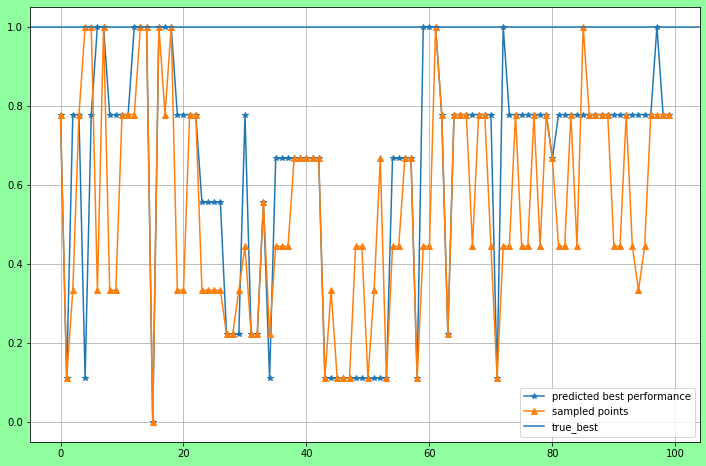

In [4]:
final_values = sampling_mvn.mean[predicted_best.long()].detach()
sampling_decisions = train_X[num_full_train * num_alternatives:]
sampling_values = sampling_mvn.mean[sampling_decisions.long()].detach()
fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor('xkcd:mint green')

plt.plot(final_values, marker="*", label="predicted best performance")
plt.plot(sampling_values, marker="^", label="sampled points")
plt.axhline(sampling_mvn.mean.max(), label="true_best")
plt.grid()
plt.legend()
plt.show()

In [5]:
train_X

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9., 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 0., 1., 2., 3., 4., 5.,
        6., 7., 8., 9., 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 7., 1., 3., 7.,
        9., 9., 3., 9., 3., 3., 7., 7., 7., 9., 9., 0., 9., 7., 9., 3., 3., 7.,
        7., 3., 3., 3., 3., 2., 2., 3., 4., 2., 2., 5., 2., 4., 4., 4., 6., 6.,
        6., 6., 6., 1., 3., 1., 1., 1., 4., 4., 1., 3., 6., 1., 4., 4., 6., 6.,
        1., 4., 4., 9., 7., 2., 7., 7., 7., 4., 7., 7., 4., 1., 4., 4., 7., 4.,
        4., 7., 4., 7., 6., 4., 4., 7., 4., 9., 7., 7., 7., 7., 4., 4., 7., 4.,
        3., 4., 7., 7., 7., 7.])